This notebook is part of the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).

This notebook is joint work by Remy Priem (primary author), Morgane Menz, Mostafa Meliani, Joseph Morlier and Emmanuel Rachelson.
Some extensions added in October 2023 by N. Bartoli and T. Lefebvre

License: CC-BY-SA-NC.

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Gaussian Process Regression (practice session)</div>

# Introduction

A surrogate model is an engineering method used when an outcome of interest cannot be easily directly measured, so a model of the outcome is used instead. Most engineering design problems require experiments and/or simulations to evaluate design objective and constraint functions as function of the design variables. For example, in order to find the optimal airfoil shape for an aircraft wing, an engineer simulates the air flow around the wing for different shape variables (length, curvature, material, ...). For many real world problems, however, a single simulation can take many minutes, hours, or even days to complete. As a result, routine tasks such as design optimization, design space exploration, sensitivity analysis become near impossible since they require a great number of function evaluations.

One way of alleviating this burden is by constructing approximation models, known as surrogate models, response surface models, *metamodels* or emulators, that mimic the behavior of the simulation model as closely as possible while being computationally cheaper to evaluate. Surrogate models are constructed using a data-driven approach. The exact, inner working of the simulation code is not assumed to be known (or even understood), solely the input-output behavior is important.

There exist multiple ways to build an approximation of a function: Artificial Neural Networks, Radial Basis Functions, Support Vector Regressions...
In all these metamodels (or surrogate models), a fundamental assumption is that the quantity of interest $y(x)$ can be written $(y(x) = \hat{y}(x) + \epsilon)$, where the residuals $\epsilon$ are independently and identically distributed normal random variables, so that fitting the model $\hat{y}(x)$ is performed by minimizing a measure over $\epsilon$.

For a practical example, take a look to this airfoil optimization tool: [http://mdolab.engin.umich.edu/webfoil](http://mdolab.engin.umich.edu/webfoil)

It has been constructed by lot of offline computations and an excellent tool developed jointly by University of Michigan, Nasa, Onera and ISAE-SUPAERO called SMT: [https://github.com/SMTorg/SMT](https://github.com/SMTorg/SMT)

The authors strongly encourage students to have a look to classical textbooks such as [1] (for the Machine learning community) or [2] (for the Aerospace engineering community).

[1]  Carl Edward Rasmussen. Gaussian Processes in Machine Learning. In Advanced lectures on machine learning, pages 63–71. Springer, 2004. Available for download at [http://www.gaussianprocess.org/gpml](http://www.gaussianprocess.org/gpml).<br>
[2]  Alexander Forrester, Andy Keane et al. Engineering design via surrogate modelling: a practical guide. John Wiley & Sons, 2008.

In [1]:
# Run this cell only to install smt in colab. If you run this notebook locally, just install smt from the terminal.
!pip install smt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.9/965.9 kB 7.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [smt]3/4 [smt]


# I. Gaussian Process Regression

The main idea behind Kriging is that the 'errors' -or more accurately, the deviations from the base model- in the predicted values $\hat{y}$, are not independent. Rather, we take the view that the errors are a systematic function of the locations of the samples.

Please recall your [previous course on GPR](https://github.com/SupaeroDataScience/machine-learning/blob/main/6%20-%20Gaussian%20Processes/Gaussian%20Processes.ipynb)

We wish to train a GPR model $\mathcal{G} = \lbrace \mathbf{X}, \mathbf{Y}, \theta \rbrace$ using the Squared Exponential function. The so-called SE Kernel is $k(x,x') =\sigma_f^2\exp\left(-\frac{(x-x')^2}{l^ 2}\right)$

where $l$ is the characteristic length-scale (noted $ls$ in the following).

Given the input data $\mathbf{y} = \left[y_1,\ldots,y_N\right]$ and $\mathbf{x} =  \left[x_1,\ldots,x_N\right]$, $N$ is the number of points in the DOE and given a covariance kernel $k(x,x')$, a Gaussian Process regressor estimates the distribution of $y(x)$ as a Gaussian $\mathcal{N}(\mu,\sigma)$ with: 
$$\mu = K_*(x)K^{-1} \mathbf{y}$$
$$\sigma(y)^2 = k(x,x) - K_*(x)K^{-1}K_*(x)^T$$
where:

$$K =
\begin{bmatrix}
k(x_1,x_1) & \ldots & k(x_1,x_N) \\
\vdots     & \ddots & \vdots \\
k(x_1,x_N) & \ldots & k(x_N,x_N)
\end{bmatrix}, \
K_*(x) = \left[k(x_1, x), \ldots, k(x_N,x)\right]$$

### On the 1D example $f(x)= (x-3.5)\sin{\frac{(x-3.5)}{\pi}}$ on $\left [ 0, 25\right ]$, we will have a naive approach.

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1592/1109985056.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('$x \sin{x}$ function')


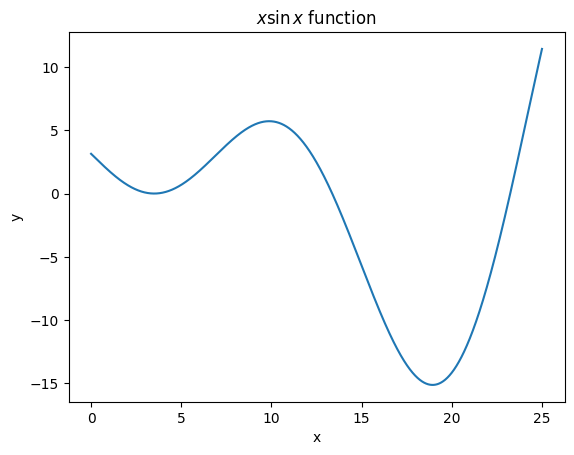

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def fun(point):
    return np.atleast_2d((point-3.5)*np.sin((point-3.5)/(np.pi)))

X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)
#y_gpr , y_std = gpr.predict(X_plot , return_std=True)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
lines.append(true_fun)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [2]:
def cov_function(point_1,point_2,ls,sig):
    ls = np.asarray(ls)
    size = point_1.shape
    dist = (point_1-point_2)**2
    k_12 = (sig**2) * np.exp(- np.sum(dist / ls**2))
    return k_12

def cov_matrix(points,ls,sig):
    ls = np.asarray(ls)
    size = points.shape
    K = np.zeros((size[0],size[0]))
    for i,point in enumerate(points):
        K[:,i] = np.array([cov_function(point,point_1,ls,sig) for point_1 in points])
    return K

def cov_vect(point,points,ls,sig):
    ls = np.asarray(ls)
    size = points.shape
    K = np.array([cov_function(point,point_1,ls,sig) for point_1 in points])
    return K

## Exercice 1:

<div class="alert alert-warning">
    
**Question 1.1**<br>
Code the function that predicts the mean and the standard deviation of the Gaussian process.
</div>

In [3]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

def myGPpredict(x_new, x_data, y_data, K_inv, ls, sig):
    K_et = cov_vect(x_new,x_data,ls,sig)
    mu = K_et.dot(K_inv.dot(y_data))[0]
    k_xx = cov_function(x_new,x_new,ls,sig)
    sigma2 = k_xx - K_et.dot(K_inv.dot(K_et.T)) #sigma * sigma
    sigma = np.sqrt(sigma2)
    return mu,sigma


<div class="alert alert-warning">
    
**Question 1.2**<br>
Test several values of hyperparameters $= [l, \sigma_f]$ with  $l$ defined as the length-scale  (of oscillations) and  $\sigma_f$ the amplitude. Look at the RMSE and R2 score that give an information on the accuracy of the model. RMSE must be close to 0 and R2 must be close to 1. For a reminder about these metrics, you can refer to https://en.wikipedia.org/wiki/Root-mean-square_deviation and https://en.wikipedia.org/wiki/Coefficient_of_determination.
</div>

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1592/47696278.py:20: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('$x \sin{x}$ function')


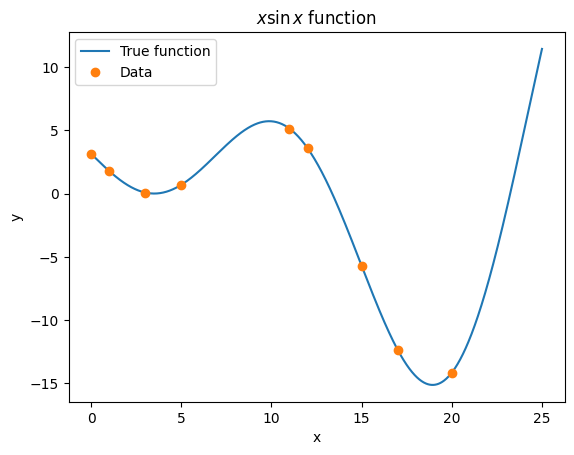

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

x_test = np.atleast_2d(np.linspace(0,25,100)).T
y_test = fun(x_test)

x_data = np.atleast_2d([0,11,20,1,5,15,12,3,17]).T
y_data = fun(x_data)


X_plot = np.atleast_2d(np.linspace(0,25,1000)).T
Y_plot = fun(X_plot)

lines = []
fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
lines.append(true_fun)
lines.append(data)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data'])
plt.show()

In [5]:
ls = [10]
sig = 4

In [6]:
# %load solutions/code2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

K = cov_matrix(x_data,ls,sig)
K_inv = np.linalg.inv(K)

y_pred = np.array([myGPpredict(x_t,x_data,y_data,K_inv,ls,sig) \
                   for x_t in X_plot])

print(len(y_pred))


1000


/tmp/ipykernel_1592/3197797719.py:10: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigma2)


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1592/1019913427.py:16: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('$x \sin{x}$ function')
/tmp/ipykernel_1592/3197797719.py:10: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigma2)


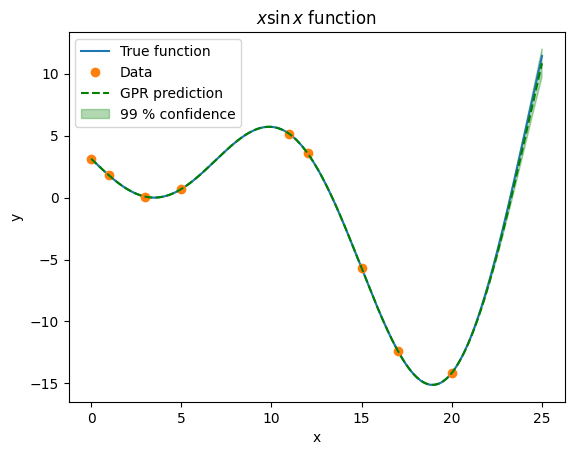

In [7]:
# RMSE = mean_squared_error(y_test,y_pred[:,0])
# R2 = r2_score(y_test,y_pred[:,0])
# print('RMSE = %.5f' %(RMSE))
# print('R2 = %.5f' %(R2))

Y_GP_plot = np.array([myGPpredict(x_t,x_data,y_data,K_inv,ls,sig) \
                   for x_t in X_plot])

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot[:,0],linestyle='--',color='g')
un_gp = ax.fill_between(X_plot.T[0],Y_GP_plot[:,0]+3*Y_GP_plot[:,1],Y_GP_plot[:,0]-3*Y_GP_plot[:,1],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

<div class="alert alert-warning">
    
**Question 1.3**<br>
Conclude: Is there a way to find a $HP_{optimal}$?
</div>

Your answer :

<div class="alert-danger"><a href="#answers1-3" data-toggle="collapse">
    
**Correction (click to unhide):**</a><br>
<div id="answers1-3" class="collapse">
TODO
</div>
</div>

# II. Hyperparameters Optimization

To train the model, the negative log marginal likelihood with respect to the hyper-parameters is minimized:

$$-\text{log}\, p(\mathbf{Y} \mid \mathbf{X}, \theta) = \frac{N}{2} \log(\frac{\mathbf{Y}^\top\mathbf{K}^{-1}\mathbf{Y}}{N}) + \frac{1}{2}\log\mid\mathbf{K}\mid + \,c,$$

where $c$ is a constant and the matrix $\mathbf{K}$ is a function of the hyper-parameters. $N $ is the number of training points.

## Exercice 2:

<div class="alert alert-warning">
    
**Question 2.1**<br>
Plot a 1D graph of the Marginal Likelihood function for $l \in [10^{-3},1.25]$ at $\sigma_f$ fixed.
</div>

In [11]:
# %load solutions/code3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

def likelihood(x_data,y_data,theta,sig):
    K = cov_matrix(x_data,theta,sig)
    args1 = y_data.T.dot(np.linalg.inv(K))
    args2 = np.log(args1.dot(y_data)/x_data.shape[0])
    args3 =  np.log(np.linalg.det(K))/2.
    like = 0.5*(x_data.shape[0])*args2 + args3
    return like[0,0]




Text(0.5, 1.0, 'Log Likelihood regarding ls')

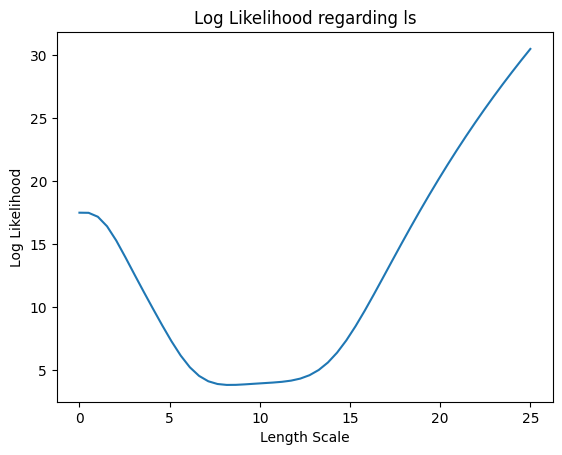

In [12]:
ls = np.linspace(1e-3,25)

like = np.array([likelihood(x_data,y_data,l,sig) for l in ls])

fig = plt.figure()
ax = fig.add_subplot(111)
line = ax.plot(ls,like)
ax.set_xlabel('Length Scale')
ax.set_ylabel('Log Likelihood')
ax.set_title('Log Likelihood regarding ls')

<div class="alert alert-warning">
    
**Question 2.2**<br>
Optimize the Marginal Likelihood function to find $l^*$.<br>Watch out: some optimizers are gradient-based and only converge to a local optimum (try different initializations).
</div>

In [14]:
from scipy.optimize import minimize

like_obj = lambda ls : likelihood(x_data,y_data,ls,sig)


# Multistart to remove bad optimization results
ls_start = np.linspace(1e-6,25,5)

In [18]:
# %load solutions/code4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

opt_all = np.array([minimize(like_obj, ls, method='SLSQP', bounds=[(1e-6,25)]) for ls in ls_start])
print(opt_all)


[     message: Optimization terminated successfully
      success: True
       status: 0
          fun: 17.48532656357761
            x: [ 1.000e-06]
          nit: 1
          jac: [ 0.000e+00]
         nfev: 2
         njev: 1
  multipliers: []
      message: Optimization terminated successfully
      success: True
       status: 0
          fun: 3.8206125025161377
            x: [ 8.350e+00]
          nit: 6
          jac: [ 2.921e-06]
         nfev: 12
         njev: 6
  multipliers: []
      message: Optimization terminated successfully
      success: True
       status: 0
          fun: 3.8206124796199976
            x: [ 8.351e+00]
          nit: 8
          jac: [ 1.429e-03]
         nfev: 21
         njev: 8
  multipliers: []
      message: Optimization terminated successfully
      success: True
       status: 0
          fun: 17.340857731930775
            x: [ 1.876e+01]
          nit: 4
          jac: [-1.141e+02]
         nfev: 47
         njev: 4
  multipliers: []
      

In [21]:
opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
ind_min = np.argmin(obj_success)

opt = opt_success[ind_min]
ls_et = opt['x']

print('Optimization results', opt)
# print('')
print('Best lenght scale is %.5f with sigma= %.5f' %(ls_et, sig) )

Optimization results      message: Optimization terminated successfully
     success: True
      status: 0
         fun: 3.8206124796199976
           x: [ 8.351e+00]
         nit: 8
         jac: [ 1.429e-03]
        nfev: 21
        njev: 8
 multipliers: []
Best lenght scale is 8.35098 with sigma= 4.00000


/tmp/ipykernel_1592/807101069.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Best lenght scale is %.5f with sigma= %.5f' %(ls_et, sig) )


# III. Optimization

Now we would like to minimize a black box function subject to boundary constraints. This function is very expensive to evaluate and only provides a scalar output (meaning that you don't have access to gradients or higher order derivatives). We will use Gaussian Process to solve this optimization problem.

Right now you can use directly `smt` which includes all these operations in a single procedure. Here, the data are the points $x_{data} = \left [0, 7, 25 \right ]$.

# Exercice 3

The `fun` function from section I will play the role of our "expensive to evaluate function".

<div class="alert alert-warning">
    
**Question 3.1**<br>
Build the GP model with a square exponential kernel with surrogate modelling toolbox (SMT) knowing $(x_{data}, y_{data})$.
</div>

<div class="alert alert-warning">
    
Be careful in `smt` $k(x,x') =\sigma_f^2\exp\left(-\theta{(x-x')^2}\right)$. So $\theta = 1/l^2$
</div>

In [22]:
from smt.surrogate_models import KRG

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)
print("Shape of x_data =",x_data.shape)

Shape of x_data = (3, 1)


In [28]:
# %load solutions/code5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).



#define the KRG object, give the DOE and train it
gpr = KRG()# some options to add theta0=[1e-2]*x_data.shape[1],print_prediction = False)
gpr.set_training_values(x_data,y_data)

gpr.train()

print('--------------')
print('Theta optimal', gpr.optimal_theta)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1907499
--------------
Theta optimal [0.82122071]


<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1592/1446256425.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('$x \sin{x}$ function')


___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0042069
   
   Prediction time/pt. (sec) :  0.0000042
   


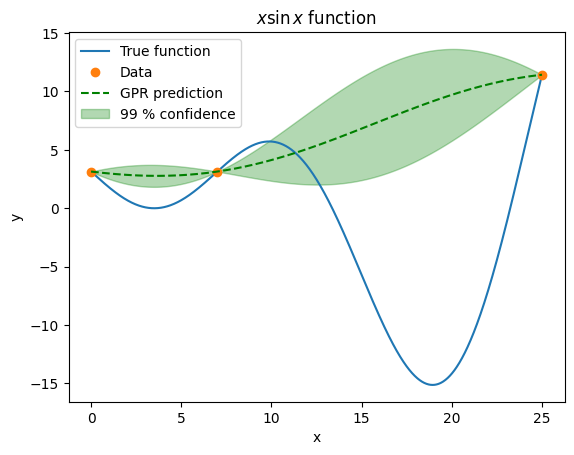

In [29]:
# query the outputs: mean and variance
Y_GP_plot = gpr.predict_values(X_plot)
sig_GP_plot = np.sqrt(gpr.predict_variances(X_plot)) #to get the standard deviation

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.atleast_2d(sig_GP_plot)
sig_moins = Y_GP_plot-3*np.atleast_2d(sig_GP_plot)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()

# Exercice 4

Suppose you are confronted to an optimization problem where each evaluation of the objective function is very expensive: let's say 10 hours per evaluation. You want to solve this problem under *computational budget contraints*.

Your challenge is: Minimize the $x \mapsto x \sin{(x)}$ function given a total computational budget of 10 points with the initial points $(x_{data},y_{data})$.

<div class="alert alert-warning">
    
**Question 4.1**<br>
Give at least 2 methods to optimize the true function thanks to Gaussian Processes. You don't have to code it explicitly, just give the main idea.
</div>

Your answer:

<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Correction Toggle Example</title>

  <!-- Bootstrap CSS -->
  <link
    rel="stylesheet"
    href="https://cdn.jsdelivr.net/npm/bootstrap@4.6.2/dist/css/bootstrap.min.css"
  >
</head>
<body class="p-3">

  <div class="alert alert-danger">
    <a href="#answers4-1" data-toggle="collapse" class="font-weight-bold text-dark">
      ⚠️ Correction (click to unhide)
    </a>
    <div id="answers4-1" class="collapse mt-2">
      ✅ Voici la correction :  
      Vous devez inclure les scripts Bootstrap JS pour que le "collapse" fonctionne.
    </div>
  </div>

  <!-- Bootstrap JS + jQuery (required for Bootstrap 4) -->
  <script src="https://code.jquery.com/jquery-3.6.4.min.js"></script>
  <script src="https://cdn.jsdelivr.net/npm/bootstrap@4.6.2/dist/js/bootstrap.bundle.min.js"></script>

</body>
</html>


# Exercice 5 : Bayesian Optimization

Bayesian optimization is defined by Jonas Mockus in [3] as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function.

[3]  J. Močkus.  On bayesian methods for seeking the extremum, pages 400–404. Springer Berlin Heidelberg, Berlin, Heidelberg, 1975.

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation is [4,5]. Kushner used [Wiener processes](https://en.wikipedia.org/wiki/Stochastic_process#Wiener_process) (Brownian motion processes) for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

[4] Harold J Kushner. A Versatile Stochastic Model of a Function of Unknown and Time-Varying Form. vol. 5, pages 150–167, 08 1962.<br>
[5] Harold J Kushner. A New Method of Locating the Maximum Point of an Arbitrary Multipeak Curve in the Presence of Noise. vol. 86, 01 1964.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in [3]. This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO [6].

[6] Donald R. Jones, Matthias Schonlau and William J. Welch. Efficient Global Optimization of Expensive Black-Box Functions. J. of Global Optimization, vol. 13, no. 4, pages 455–492, 1998.

## Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in |6].

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_N\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_N\}$. We denote $D=(X,Y)$ the corresponding design of experiment with $Card(D)=N$. We build a Kriging model (also called Gaussian process) with a mean function $\mu_D$ and a variance function $\sigma^{2}_D$. For each point $x$ in the design space, the model prediction $y_x^D$ follows a gaussian distribution. $y_x^D \sim \mathcal{N}(\mu_D(x),\sigma^{2}_D(x))$

The next step is to compute the criterion EI. To do this, let us write:

$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$

The Expected Improvement funtion (EI) can be expressed as:

$$E[I(x)] = E[\max(f_{min}-y_x^D, 0)]$$

By rewriting the right-hand side of EI's expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form:

$$
E[I(x)] = (f_{\min} - \mu_D(x))\,\Phi\!\left(\frac{f_{\min} - \mu_D(x)}{\sigma_D(x)}\right)
+ \sigma_D(x)\,\phi\!\left(\frac{f_{\min} - \mu_D(x)}{\sigma_D(x)}\right)
$$


where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$ \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

<div class="alert alert-warning">
    
**Question 5.1**<br>
Implement the Expected Improvement function.
</div>

In [ ]:
from scipy.stats import norm

In [ ]:
# %load solutions/code6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).
def EI(GP,points,f_min):
    #to complete
    return ei

In [ ]:
Y_GP_plot = gpr.predict_values(X_plot)
var_GP_plot = gpr.predict_variances(X_plot)
sig_GP_plot = np.sqrt(var_GP_plot)
Y_EI_plot = EI(gpr,X_plot,np.min(y_data))
print(Y_EI_plot.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.atleast_2d(sig_GP_plot)
sig_moins = Y_GP_plot-3*np.atleast_2d(sig_GP_plot)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
ax1 = ax.twinx()
ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
lines = [true_fun,data,gp,un_gp,ei]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax1.set_ylabel('ei')
fig.legend(lines,['True function','Data','GPR prediction','99 % confidence','Expected Improvement'],loc=[0.13,0.64])
plt.show()

##### <div class="alert alert-warning">
    
**Question 5.2**<br>
Complete the code of the EGO method and compare it to other infill criteria.
- SBO (surrogate based optimization): directly using the prediction of the surrogate model ($\mu$)
- LCB (Lower Confidence bound): using the confidence interval : $\mu -3 \times \sigma$
</div>

In [ ]:
#surrogate Based optimization: min the Surrogate model by using the mean mu
def SBO(GP,point):
    res = GP.predict_values(point)
    return res

#lower confidence bound optimization: minimize by using mu - 3*sigma
def LCB(GP,point):
    pred = GP.predict_values(point)
    var = GP.predict_variances(point)
    res = pred-3.*np.sqrt(var)
    return res

plt.ion()

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

#to save the init data
x_data_init = x_data
y_data_init = y_data

n_iter = 10

gpr = KRG(theta0=[1e-2]*x_data.shape[1],print_prediction = False,print_global=False)
gpr.set_training_values(x_data,y_data)

gpr.train()

In [ ]:
# %load solutions/code7.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


for k in range(n_iter):
    
#to complete


In [ ]:
print('Results : X = %s, Y = %s' %(x_opt,y_opt))

Y_GP_plot = gpr.predict_values(X_plot)
sig_GP_Plot = np.sqrt(gpr.predict_variances(X_plot))
Y_EI_plot = EI(gpr,X_plot,np.min(y_data))

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
data_init, = ax.plot(x_data_init,y_data_init[:,-1],linestyle='',marker='o',color='b')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
opt, =  ax.plot(x_opt,y_opt,linestyle='',marker='*',markersize=14,color='r')
sig_plus = Y_GP_plot+3*np.atleast_2d(sig_GP_Plot)
sig_moins = Y_GP_plot-3*np.atleast_2d(sig_GP_Plot)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,data_init,opt,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data added','Data init','Best found point','GPR prediction','99 % confidence'])
plt.show()

In [ ]:
#to get an animation with the iterative process
# %load solutions/code7bis.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML

#to run the solution 

## Super Efficient Global Optimization

In the following we describe the Super Efficient Global Optimization (SEGO) algorithm as published in [].
SEGO is a direct extension of EGO for constrained optimization problems.

Let the following constrained optimization problem:
\begin{equation}
    x^* = \underset{x\in \Omega}{argmin} ~~ f(x)  ~~ \mbox{ such that } ~~ g(x)\geq 0  \mbox{ and} ~~ h(x)=0
\end{equation}
where the constraints are defined by :

$g: \mathbb{R}^d \to \mathbb{R}^m$ ($m$ inequality constraints)

$h: \mathbb{R}^d \to \mathbb{R}^p$ ($p$ equality constraints)


The Constrained Bayesian optimization (CBO) algorithm is quite similar as the one of the unconstrained BO approach except that the optimization sub-problem solved to enrich the DoE takes into account the constraints. The associated sub-problem can take two forms: it can be unconstrained and tries to optimize an adapted function which gathers the constraints and the classical criterion [7]; or it can be constrained and optimizes one of the previous acquisition functions with some feasibility criteria associated to the constraints $g$ and $h$ [10]. Here the focus is made on constrained optimization sub-problem methods. The optimization sub-problem is of the form
\begin{equation}
    x_{next} = \underset{x \in \Omega}{argmax} ~ \alpha (x)  ~~ \text{with} ~~  x \in \Omega_h \cap \Omega_g
    \label{Constrained enrichment optimization sub-problem}
\end{equation}
where $\alpha$ is the acquisition function (the expected improvement for example) $\Omega_h$ and $\Omega_g$ are respectively the feasible domains defined by the two feasibility criteria: $\alpha_h: \mathbb{R}^d \to \mathbb{R}^p$ and $\alpha_g: \mathbb{R}^d \to \mathbb{R}^m$. To construct the feasibility criteria, the approaches named Super Efficient Global Optimization (SEGO) [11] and the Super Efficient Global Optimization coupled with Mixture Of Experts (SEGOMOE) [8,9,10] use the posterior means of the GPs that modelize the constraints as feasibility criterion: $\alpha_h= \hat{\mu}_h$ and $\alpha_g = \hat{\mu}_g$. The feasible domains are $\Omega_h = \{ x, \alpha_h(x)=0 \}$ and $\Omega_g = \{ x, \alpha_g(x) \geq 0 \}$. %As things progress, the feasible domain $\Omega_h \cap \Omega_g$ will become clearer.


[7] Hernandez-Lobato,  J.M.,  Gelbart,  M.A.,  Adams,  R.P.,  Hoffman,  M.W.,  Ghahramani,  Z.:  A  generalframework for constrained bayesian optimization using information-based search (2016)

[8] Bartoli, N., Bouhlel, M.A., Kurek, I., Lafage, R., Lefebvre, T., Morlier, J., Priem, R., Stilz, V., Regis,R.:  Improvement  of  efficient  global  optimization  with  application  to  aircraft  wing  design.  In:  17thAIAA/ISSMO Multidisciplinary analysis and optimization conference. p. 4001 (2016)

[9] Bartoli, N., Lefebvre, T., Dubreuil, S., Olivanti, R., Bons, N., Martins, J.R., Bouhlel, M.A., Morlier,J.:  An  adaptive  optimization  strategy  based  on  mixture  of  experts  for  wing  aerodynamic  design  op-timization.  In:  18th  AIAA/ISSMO  Multidisciplinary  Analysis  and  Optimization  Conference.  p.  4433(2017)
  
[10] Bartoli,  N.,  Lefebvre,  T.,  Dubreuil,  S.,  Olivanti,  R.,  Priem,  R.,  Bons,  N.,  Martins,  J.R.,  Morlier,  J.:Adaptive modeling strategy for constrained global optimization with application to aerodynamic wingdesign. Aerospace Science and technology90, 85–102 (2019)

[11] Sasena, M.J.: Flexibility and efficiency enhancements for constrained global design optimization withkriging approximations. Ph.D. thesis, Citeseer (2002)

In the following we will consider the same function as before as objective function: $f(x)= (x-3.5)\sin{\frac{(x-3.5)}{\pi}}$ on $\left [ 0, 25\right ]$.

An inequality constraint is added: $x < 11$

<div class="alert alert-warning">
    
**Question 5.3**<br>
Complete the code the constraint function $g$.
</div>

In [ ]:
# %load solutions/code8.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

#define the constraint function g
def g(x):
   #to complete
    return y

In [ ]:
x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)
y_data_con = g(x_data)

n_iter = 17

# construct the grp for the objective
gpr = KRG(theta0=[1e-2]*x_data.shape[1],print_prediction = False,print_global=False)
gpr.set_training_values(x_data,y_data)

gpr.train()

# construct the grp for the constraint
gpr_con = KRG(theta0=[1e-2]*x_data.shape[1],print_prediction = False,print_global=False)
gpr_con.set_training_values(x_data,y_data_con)

gpr_con.train()

<div class="alert alert-warning">
    
**Question 5.4**<br>
Complete the code of the SEGO method and compare it to other infill criteria.
</div>

In [ ]:
# %load solutions/code9.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

for k in range(n_iter):
#to complete

In [ ]:
print('Results : X = %s, Y = %s' %(x_opt,y_opt))

Y_GP_plot = gpr.predict_values(X_plot)
sig_GP_Plot = np.sqrt(gpr.predict_variances(X_plot))
Y_con_GP_plot = gpr_con.predict_values(X_plot)

fig = plt.figure()
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.atleast_2d(sig_GP_Plot)
sig_moins = Y_GP_plot-3*np.atleast_2d(sig_GP_Plot)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
gp_con, = ax.plot(X_plot,Y_con_GP_plot,linestyle='--',color='pink')

index_lim = 440
print("X_plot[index_lim]=",X_plot[index_lim])

unfeasible_domain = ax.fill_between(X_plot.T[0,index_lim:], 0, 1,
                color='pink', alpha=0.3, transform=ax.get_xaxis_transform())

lines = [true_fun,data,gp,un_gp,gp_con,unfeasible_domain]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence','GPR prediction for the constraint',"unfeasible domain"])

plt.show()

# Recap: Play with a web app from Rasmussen

[http://www.infinitecuriosity.org/vizgp/](http://www.infinitecuriosity.org/vizgp/)

## BONUS: Try with a 2D function with 2D Rosenbrock function

Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$
    

In [ ]:
def rosenbrock(point):
    #  Rosenbrock function

    res = (1.0 - point[:,0])**2 + 100*(point[:,1] - point[:,0]**2)**2
    return res

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

print('---------------------------')
print('PLOT  2D Rosenbrock ')
ndim = 2

num_plot = 50 #to plot rosenbrock

xlimits=np.array([[-2,2], [-2,2]])


#To plot the Rosenbrock function
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


### Optimum for Rosen using the minimize with SLSQP

In [ ]:
from scipy.optimize import minimize

x0_Rosen = np.array([0, 0])

Bound_Rosen = [(-2,2)]
res = minimize(lambda x: float(rosenbrock(np.atleast_2d(x))), x0_Rosen, method='SLSQP', bounds=Bound_Rosen)

print('A local optimal point with initial conditions ' + str(x0_Rosen) + ' is found in ' + str(res.x) +' with the value ' + str(res.fun))
print('A SLSQP algorithm from scipy has been used')


### Use LHS from SMT to create initial DOE

In [ ]:
from smt.sampling_methods import LHS
ndoe = 8 #(at least ndim+1)
sampling = LHS(xlimits=xlimits)
x_data = sampling(ndoe)
y_data=rosenbrock(x_data)

#to save the init data
x_data_init = x_data
y_data_init = y_data



gpr = KRG(theta0=[1e-2]*x_data.shape[1],print_prediction = False,print_global=False)
gpr.set_training_values(x_data,y_data)

gpr.train()

n_iter = 40

In [ ]:
# %load solutions/code10.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

for k in range(n_iter):
#to complete

print('With given '+str(n_iter)+' budget, optimal point  is found in ' + str(x_opt) +' with the value ' + str(y_opt))

### Plot the results

In [ ]:
doe = x_data
response = y_data
doe_size=ndoe
#
num = 100
x = np.linspace(-2., 2., num)
y = np.linspace(-2., 2., num)
xv, yv = np.meshgrid(x, y)

x_test = np.array([np.ravel(xv), np.ravel(yv)]).T
z_test = np.zeros([num*num, 1])

z_test = rosenbrock(x_test)
fig1 = plt.figure(figsize=(8, 6))
axSurrogate1 = fig1.add_subplot(111)
surf1 = axSurrogate1.contour(xv, yv, z_test.reshape((num, num)),
                             150, cmap=cm.PiYG, antialiased=True, alpha=0.6)

scatter2 = axSurrogate1.scatter(doe.T[0][0:doe_size], doe.T[1][0:doe_size],
                                s=20., c='b', label='Initial DOE')
scatter2 = axSurrogate1.scatter(doe.T[0][doe_size:], doe.T[1][doe_size:],
                                s=20., c='r', label='Enrich points')
scatter3 = axSurrogate1.scatter(1,1,
                                s=30.,marker = 'x', c='C2', label='True Optimum')
axSurrogate1.set_xlim([-2, 2])
axSurrogate1.set_ylim([-2, 2])
axSurrogate1.set_title(r'2D Rosen Function', fontsize=12)
axSurrogate1.legend()
#fig1.show()


plt.show()

## BONUS: use directly the EGO function within the SMT toolbox

In [49]:
from smt.applications.ego import EGO
from smt.sampling_methods import LHS
from smt.utils.design_space import DesignSpace
import pandas as pd
print('---------------------------')
print('TEST EGO on   2D Rosenbrock  with SMT toolbox (2.0 version and above)') 

---------------------------
TEST EGO on   2D Rosenbrock  with SMT toolbox (2.0 version and above)


* Choose your criterion to perform the optimization: EI, SBO or LCB
* Choose the size of the initial DOE
* Choose the number of EGO iterations

In [ ]:
#SMT version 2.0 with design_space defined
design_space = DesignSpace(xlimits)

criterion='EI' #'EI' or 'SBO' or 'LCB'

#number of points in the initial DOE
ndoe = 5 #(at least ndim+1)

#number of iterations with EGO 
n_iter =50

#Build the initial DOE
#generate the DOE with LHS sampling

sampling = LHS(xlimits=xlimits, random_state=0)
xdoe = sampling(ndoe)
xdoe_init =  np.array(xdoe[[0,1]])
ydoe_init = rosenbrock(xdoe_init)
print('xdoe',xdoe_init,'\n','ydoe',ydoe_init)

#EGO call (given xdoe as inputs)
#if ydoe is known, possibility to add it as inputs
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe_init,
    ydoe=ydoe_init,
    surrogate=KRG(design_space=design_space, print_global=False),
)
x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)
print('Xopt for Rosenbrock ', x_opt,y_opt, ' obtained using EGO criterion = ', criterion )
print('Check if the optimal point is close to the reference solution Xopt= (1,1) with the Y value=0')
print('if not you can increase the number of iterations with n_iter but the CPU will increase also.')
print('---------------------------')


In [ ]:
#To plot the Rosenbrock function
#3D plot
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
#to add the points provided by EGO
ax.scatter(x_data[:ndoe,0],x_data[:ndoe,1],y_data[:ndoe],zdir='z',marker = '.',c='k',s=100, label='Initial DOE')
ax.scatter(x_data[ndoe:,0],x_data[ndoe:,1],y_data[ndoe:],zdir='z',marker = 'x',c='r', s=100, label= 'Added point')
ax.scatter(x_opt[0],x_opt[1],y_opt,zdir='z',marker = '*',c='g', s=100, label= 'EGO optimal point')

plt.title(' Rosenbrock function during EGO algorithm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


#2D plot 
#to add the points provided by EGO
plt.plot(x_data[:ndoe,0],x_data[:ndoe,1],'.', label='Initial DOE')
plt.plot(x_data[ndoe:,0],x_data[ndoe:,1],'x', c='r', label='Added point')
plt.plot(x_opt[:1],x_opt[1:],'*',c='g', label= 'EGO optimal point')
plt.plot([1], [1],'*',c='m', label= 'Optimal point')

plt.title(' Rosenbrock function during EGO algorithm with '+str(criterion) )
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()